# STK-IN4300, oblig 2, Kristian Wold

In [1]:
#install.packages("RcmdrMisc")
#install.packages("glmnet")
#install.packages("caret")
#install.packages("mgcv")
#install.packages("tree")
#install.packages("mlbench")
#install.packages("class")
#install.packages("randomForest")
#install.packages("ada")


library(caret)     #preprocess and scale
library(RcmdrMisc) #subselection
library(glmnet)    #ridge
library(mgcv)      #gam
library(rpart)     #trees
library(tree)      #trees
library(mlbench)   #Pima data
library(class)     #knn
library(randomForest) #random forest
library(ada)          #ada boost

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: car
Loading required package: carData
Loading required package: sandwich
Loading required package: Matrix
Loaded glmnet 4.0-2
Loading required package: nlme
This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
setwd("~/Documents/STK-IN4300/oblig2-2")

### Loading data

In [3]:
data <- read.csv(file = 'qsar_aquatic_toxicity.csv', header = FALSE, sep=";")
colnames(data) = cbind("TPSA", "SAacc", "H050", "MLOGP", "RDCHI", "GATS1p", "nN", "C040", "LC50")

summary(data)

      TPSA            SAacc             H050             MLOGP       
 Min.   :  0.00   Min.   :  0.00   Min.   : 0.0000   Min.   :-6.446  
 1st Qu.: 15.79   1st Qu.: 11.00   1st Qu.: 0.0000   1st Qu.: 1.232  
 Median : 40.46   Median : 42.68   Median : 0.0000   Median : 2.273  
 Mean   : 48.47   Mean   : 58.87   Mean   : 0.9377   Mean   : 2.313  
 3rd Qu.: 70.02   3rd Qu.: 77.49   3rd Qu.: 1.0000   3rd Qu.: 3.393  
 Max.   :347.32   Max.   :571.95   Max.   :18.0000   Max.   : 9.148  
     RDCHI           GATS1p            nN              C040        
 Min.   :1.000   Min.   :0.281   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:1.975   1st Qu.:0.737   1st Qu.: 0.000   1st Qu.: 0.0000  
 Median :2.344   Median :1.020   Median : 1.000   Median : 0.0000  
 Mean   :2.492   Mean   :1.046   Mean   : 1.004   Mean   : 0.3535  
 3rd Qu.:2.911   3rd Qu.:1.266   3rd Qu.: 2.000   3rd Qu.: 0.0000  
 Max.   :6.439   Max.   :2.500   Max.   :11.000   Max.   :11.0000  
      LC50       
 Min.   : 0.122 

By inspection, some factors of the counting features occure very rarly. These are promptly removed, becaue it can lead to problems if these factors appear in the test data, but not the train data, as their associated parameter will be undefined. This is not a ideal fix, but will be done for all models to ensure a common testing ground.

In [4]:
data <- data[data$H050<6,]
data <- data[data$nN<6,]
data <- data[data$C040 < 3,]

# Problem 1

### Train-Test Split:

In [5]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

## Model with numeric features

In [6]:
fit_numeric_features <- lm(LC50 ~ ., data = train)

y_predicted_train = predict.lm(fit_numeric_features, train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.lm(fit_numeric_features, test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

summary(fit_numeric_features)

[1] "MSE train: 1.30751886771986"
[1] "MSE test: 1.55471329781609"



Call:
lm(formula = LC50 ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6160 -0.8128 -0.1343  0.6174  3.8872 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.768081   0.304962   9.077  < 2e-16 ***
TPSA         0.030000   0.003575   8.392 1.74e-15 ***
SAacc       -0.016395   0.002706  -6.060 3.96e-09 ***
H050        -0.115121   0.086407  -1.332  0.18374    
MLOGP        0.430367   0.082784   5.199 3.66e-07 ***
RDCHI        0.502127   0.169634   2.960  0.00331 ** 
GATS1p      -0.498033   0.199199  -2.500  0.01293 *  
nN          -0.160385   0.069173  -2.319  0.02107 *  
C040        -0.123879   0.126760  -0.977  0.32920    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.16 on 309 degrees of freedom
Multiple R-squared:  0.4923,	Adjusted R-squared:  0.4791 
F-statistic: 37.45 on 8 and 309 DF,  p-value: < 2.2e-16


## Model with categorical features

In [7]:
#change numeric features to categorical

train$H050 <- as.factor(train$H050)
test$H050 <- as.factor(test$H050)

train$nN <- as.factor(train$nN)
test$nN <- as.factor(test$nN)

train$C040 <- as.factor(train$C040)
test$C040 <- as.factor(test$C040)

In [8]:
fit_factor_features <- lm(LC50 ~ ., data = train)

y_predicted_train = predict.lm(fit_factor_features, train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.lm(fit_factor_features, test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

summary(fit_factor_features)

[1] "MSE train: 1.26402963181602"
[1] "MSE test: 1.50345969915486"



Call:
lm(formula = LC50 ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9250 -0.7585 -0.0751  0.6081  4.0081 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.739701   0.317755   8.622 3.86e-16 ***
TPSA         0.028896   0.003647   7.924 4.55e-14 ***
SAacc       -0.016259   0.002885  -5.636 4.00e-08 ***
H0501       -0.107165   0.184973  -0.579  0.56278    
H0502       -0.430947   0.230076  -1.873  0.06203 .  
H0503       -0.465218   0.417858  -1.113  0.26645    
H0504        0.124275   0.486665   0.255  0.79862    
H0505       -0.167273   0.771160  -0.217  0.82843    
MLOGP        0.431470   0.085405   5.052 7.61e-07 ***
RDCHI        0.494350   0.176183   2.806  0.00535 ** 
GATS1p      -0.513390   0.203741  -2.520  0.01226 *  
nN1          0.238308   0.169115   1.409  0.15983    
nN2         -0.263349   0.231622  -1.137  0.25645    
nN3         -0.183813   0.328837  -0.559  0.57659    
nN4         -0.837986   0.482289  -1.

Comparing the models, we see that the numeric features of the first model are more significant than the categorical features of the second model. This is because in splitting the numeric features into categorical features, we get more parameters to estimate. The training examples will be split amoung the new categorical features, resulting in less data for estimation per parameter and thus less significance. 

Still, the models perform similarly good, both achieveing around 1.55 MSE on test. This might be a result of the fact that our model is in a sense regularized, in the sense that categories in the data set that appeared very rearly was removed. These would result in the least significant parameters, but also caused bugs in R in the case that a category appeared in the test data, but not the training data.

On the other hand, having more parameters, the second model is more expressive. It's not given that a numeric 
representation of the counting features is justified. This enforces a linear structure, in the sense that two atoms contribute twice as much to the response as one atom. This might be far from the true nature of the system, and categorical features might be more appropriate.

### Repeat 200 times

In [9]:
set.seed(42)
mse_numeric = 0
mse_factor = 0
for (i in 1:200)
{
    n = nrow(data)
    train_size = floor(0.75*n)
    train_idx = sample(seq_len(n), size = train_size)

    train = data[train_idx,]
    test = data[-train_idx,]
    
    #numeric features
    lm_numeric_features <- lm(LC50 ~ ., data = train)
    mse_numeric = mse_numeric + mean((test$LC50 - predict.lm(lm_numeric_features, test))^2)
    
    
    #factor features
    train$H050 <- as.factor(train$H050)
    train$nN <- as.factor(train$nN)
    train$C040 <- as.factor(train$C040)
    
    
    test$H050 <- as.factor(test$H050)
    test$nN <- as.factor(test$nN)
    test$C040 <- as.factor(test$C040)
    
    
    
    lm_factor_features <- lm(LC50 ~ ., data = train)
    mse_factor = mse_factor + mean((test$LC50 - predict.lm(lm_factor_features, test))^2) 
}
print(paste0("Average MSE on test data for model with numeric features: ", mse_numeric/200))
print(paste0("Average MSE on test data for model with factor features: ", mse_factor/200))


[1] "Average MSE on test data for model with numeric features: 1.44059515148494"
[1] "Average MSE on test data for model with factor features: 1.45521686010559"


Averaging the previous procedure over 200 runs, the models perform approximatly equally good.

## Subset selection

In [10]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

In [11]:
full_model = lm(LC50 ~ ., data = train)

forwardAIC_model = stepwise(full_model, direction = "forward", criterion = "AIC", trace=0)
backwardAIC_model = stepwise(full_model, direction = "backward", criterion = "AIC", trace=0)
summary(forwardAIC_model)
summary(backwardAIC_model)

forwardBIC_model = stepwise(full_model, direction = "forward", criterion = "BIC", trace=0)
backwardBIC_model = stepwise(full_model, direction = "backward", criterion = "BIC", trace=0)
summary(forwardBIC_model)
summary(backwardBIC_model)


Direction:  forward
Criterion:  AIC 


Direction:  backward
Criterion:  AIC 




Call:
lm(formula = LC50 ~ MLOGP + TPSA + SAacc + nN + RDCHI + GATS1p, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7286 -0.7679 -0.0836  0.6409  3.9532 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.655168   0.285699   9.294  < 2e-16 ***
MLOGP        0.471520   0.077119   6.114 2.91e-09 ***
TPSA         0.031087   0.003482   8.929  < 2e-16 ***
SAacc       -0.018534   0.002288  -8.099 1.27e-14 ***
nN          -0.167722   0.068152  -2.461  0.01440 *  
RDCHI        0.460664   0.167221   2.755  0.00622 ** 
GATS1p      -0.440959   0.193700  -2.277  0.02350 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.16 on 311 degrees of freedom
Multiple R-squared:  0.4886,	Adjusted R-squared:  0.4788 
F-statistic: 49.53 on 6 and 311 DF,  p-value: < 2.2e-16



Call:
lm(formula = LC50 ~ TPSA + SAacc + MLOGP + RDCHI + GATS1p + nN, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7286 -0.7679 -0.0836  0.6409  3.9532 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.655168   0.285699   9.294  < 2e-16 ***
TPSA         0.031087   0.003482   8.929  < 2e-16 ***
SAacc       -0.018534   0.002288  -8.099 1.27e-14 ***
MLOGP        0.471520   0.077119   6.114 2.91e-09 ***
RDCHI        0.460664   0.167221   2.755  0.00622 ** 
GATS1p      -0.440959   0.193700  -2.277  0.02350 *  
nN          -0.167722   0.068152  -2.461  0.01440 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.16 on 311 degrees of freedom
Multiple R-squared:  0.4886,	Adjusted R-squared:  0.4788 
F-statistic: 49.53 on 6 and 311 DF,  p-value: < 2.2e-16



Direction:  forward
Criterion:  BIC 


Direction:  backward
Criterion:  BIC 




Call:
lm(formula = LC50 ~ MLOGP + TPSA + SAacc, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7374 -0.8233 -0.0893  0.6195  3.9626 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.572494   0.170071  15.126  < 2e-16 ***
MLOGP        0.663817   0.044389  14.955  < 2e-16 ***
TPSA         0.031762   0.003091  10.275  < 2e-16 ***
SAacc       -0.016191   0.002122  -7.629 2.86e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.18 on 314 degrees of freedom
Multiple R-squared:  0.466,	Adjusted R-squared:  0.4608 
F-statistic: 91.32 on 3 and 314 DF,  p-value: < 2.2e-16



Call:
lm(formula = LC50 ~ TPSA + SAacc + MLOGP, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7374 -0.8233 -0.0893  0.6195  3.9626 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.572494   0.170071  15.126  < 2e-16 ***
TPSA         0.031762   0.003091  10.275  < 2e-16 ***
SAacc       -0.016191   0.002122  -7.629 2.86e-13 ***
MLOGP        0.663817   0.044389  14.955  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.18 on 314 degrees of freedom
Multiple R-squared:  0.466,	Adjusted R-squared:  0.4608 
F-statistic: 91.32 on 3 and 314 DF,  p-value: < 2.2e-16


Forward selection and backward elimination both produce a sequence of models with different number of features.
Forward selection starts with the empty model, and in sequence adds the most significant feature. Backwards elimination starts with the full model, and removes the least significant feature. These are greedy searches. Consider forward selection: It starts by adding the most significant feature, but this does not necesarily mean that this feature is part of the best (exhaustive) subset. Even though the first feature is most significant in isolation, it might be less significant in combination with other features. This is due to correlations among features. 

In this example, forward and backward with AIC picked the same 6 features, and forward and backward BIC picked the same 3 features. This could mean that there is little correlation among the features, based on what was discussed earlier, so the methods ends up converging.

In [12]:
y_predicted_train = predict.lm(forwardAIC_model, train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.lm(forwardAIC_model, test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print("AIC")
print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

y_predicted_train = predict.lm(forwardBIC_model, train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.lm(forwardBIC_model, test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print("AIC")
print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

[1] "AIC"
[1] "MSE train: 1.31690411431654"
[1] "MSE test: 1.50775090112642"
[1] "AIC"
[1] "MSE train: 1.37530820219062"
[1] "MSE test: 1.63328571850494"


## Ridge regression

In [13]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

x_train = as.matrix(train[,-9])
y_train = as.matrix(train$LC50)

x_test = as.matrix(test[,-9])
y_test = as.matrix(test$LC50)

scaler = preProcess(x_train)
x_train = predict(scaler, x_train)
x_test = predict(scaler, x_test)

#grid of lambdas
grid = 10^seq(-5, -1, length = 20)

### CV, 10-fold

[1] "Best lambda found with CV: 0,0233572146909012"
[1] "MSE train: 1,31015102077389"
[1] "MSE test: 1,55855828284869"


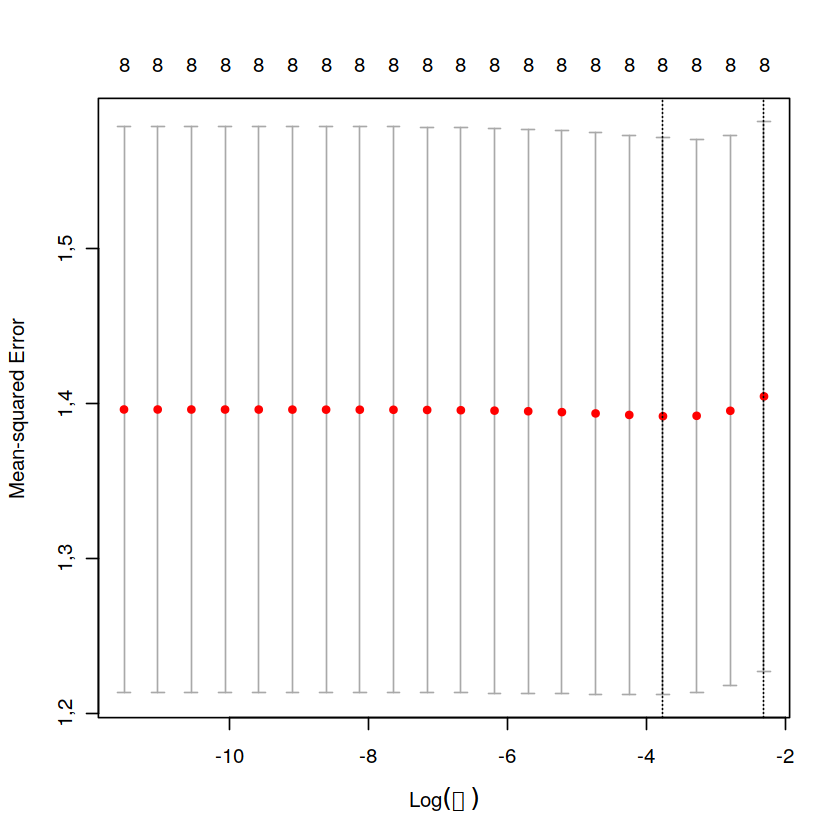

In [14]:
cv_out = cv.glmnet(x_train, y_train, lambda = grid, 
                   type.measure = "deviance", nfolds = 10, trace.it = 0, alpha = 0)

plot(cv_out)
opt_lambda <- cv_out$lambda.min #best lambda
print(paste0("Best lambda found with CV: ", opt_lambda))
fit = cv_out$glmnet.fit #all fitted models

y_predicted_train <- predict(fit, s = opt_lambda, newx = x_train)
mse_train = mean((y_predicted_train - y_train)^2)

y_predicted_test <- predict(fit, s = opt_lambda, newx = x_test)
mse_test = mean((y_predicted_test - y_test)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

From the above plot, the best Ridge model was found for lambda equal $0.023$. However, as seen from the variance in MSE estimated from CV, this model is not signifcantly better than the least penalized model with lambda $10^{-5}$, which is almost unpenalised. With test mse of $1.56$, it is not any better than ordinary OLS.

### Bootstrap

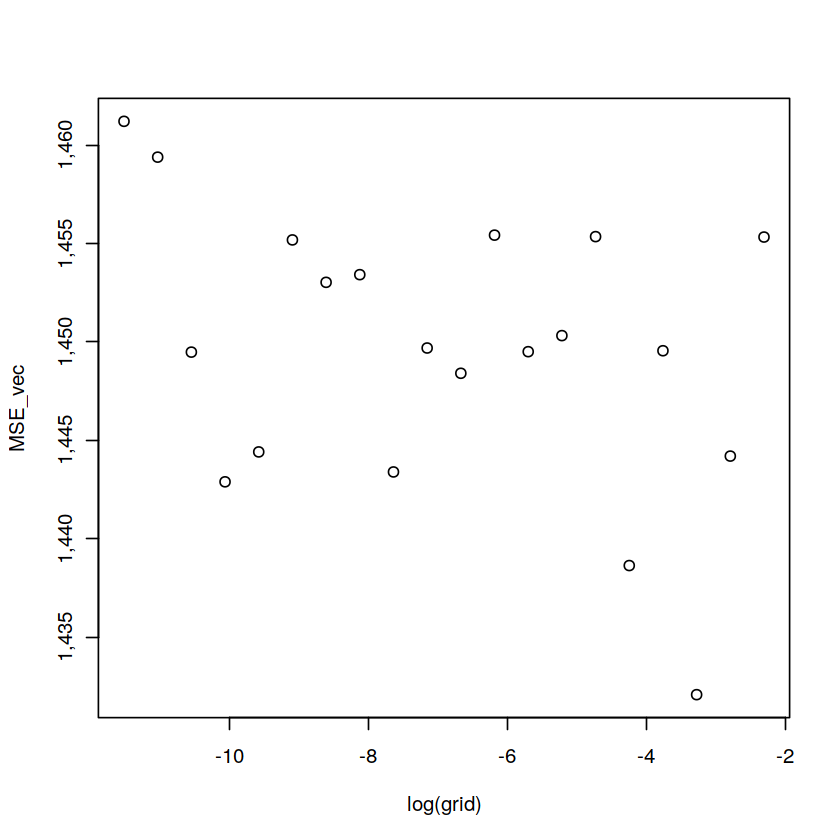

In [15]:
set.seed(42)
n = nrow(x_train)
B = 1000
MSE_vec = rep(0,20)

for (i in 1:20)
{
    MSE = 0
    for (j in 1:B)
    {
        idx = sample(seq_len(n), size = n, replace = TRUE)

        fit = glmnet(x_train[idx,], y_train[idx,], lambda = grid[i], alpha = 0)
        #predict on out of sample
        y_predicted = predict(fit, newx = x_train[-idx,])  
        MSE = MSE + mean((y_predicted - y_train[-idx,])^2)
    }
    MSE_vec[i] = MSE/B
}
plot(log(grid), MSE_vec)

Bootstrap turned out fluctuate randomly between the different values of lamba. As seen from the scale of the y-axis, the variance between the MSE caluclated for differnet values of lambda is small, again indicating that the models are nearly equally good.

## Smoothing splines

In [16]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

### Cubic smoothing splines

Fitting a GAM with smoothing cubic splines applied on each feature. Because of repeated values for categorical data, the number of knots for these features needed to be reduced.

In [17]:
fit = gam(LC50 ~ s(TPSA, bs="cr") + 
          s(SAacc, bs="cr") + 
          s(H050, bs="cr", k = 6) + 
          s(MLOGP, bs="cr") + 
          s(RDCHI, bs="cr") + 
          s(GATS1p, bs="cr") +
          s(nN, bs="cr", k = 6) + 
          s(C040, bs="cr", k = 3),
          data=train)

summary(fit)

Warning message in printCoefmat(x$p.table, digits = digits, signif.stars = signif.stars, :
“NAs introduced by coercion”Warning message in printCoefmat(x$s.table, digits = digits, signif.stars = signif.stars, :
“NAs introduced by coercion”


Family: gaussian 
Link function: identity 

Formula:
LC50 ~ s(TPSA, bs = "cr") + s(SAacc, bs = "cr") + s(H050, bs = "cr", 
    k = 6) + s(MLOGP, bs = "cr") + s(RDCHI, bs = "cr") + s(GATS1p, 
    bs = "cr") + s(nN, bs = "cr", k = 6) + s(C040, bs = "cr", 
    k = 3)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4,6955     0,0574   81,81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df      F p-value    
s(TPSA)   8,731  8,965 15,656 < 2e-16 ***
s(SAacc)  7,939  8,598  6,524 < 2e-16 ***
s(H050)   1,911  2,352  3,877 0,01454 *  
s(MLOGP)  4,814  5,740 10,027 < 2e-16 ***
s(RDCHI)  4,878  5,773  0,730 0,52122    
s(GATS1p) 1,000  1,000  5,725 0,01738 *  
s(nN)     3,914  4,438  3,948 0,00303 ** 
s(C040)   1,000  1,000  2,348 0,12655    
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

R-sq.(adj) =  0,594   Deviance explained = 63,

In [18]:
y_predicted_train = predict.gam(fit, newdata = train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.gam(fit, newdata = test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

[1] "MSE train: 0,931773983678445"
[1] "MSE test: 1,81989094666385"


### Reduced number of knots

To regularize the model and reduce complexity, the number of knots for each spline was reduced to 5

In [19]:
fit = gam(LC50 ~ s(TPSA, bs="cr") + 
          s(SAacc, bs="cr", k = 6) + 
          s(H050, bs="cr", k = 6) + 
          s(MLOGP, bs="cr", k = 6) + 
          s(RDCHI, bs="cr", k = 6) + 
          s(GATS1p, bs="cr", k = 6) +
          s(nN, bs="cr", k = 6) + 
          s(C040, bs="cr", k = 3),
          data=train)

In [20]:
y_predicted_train = predict.gam(fit, newdata = train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict.gam(fit, newdata = test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

[1] "MSE train: 0,99090074686936"
[1] "MSE test: 1,80814104728237"


### Regression tree

In [21]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

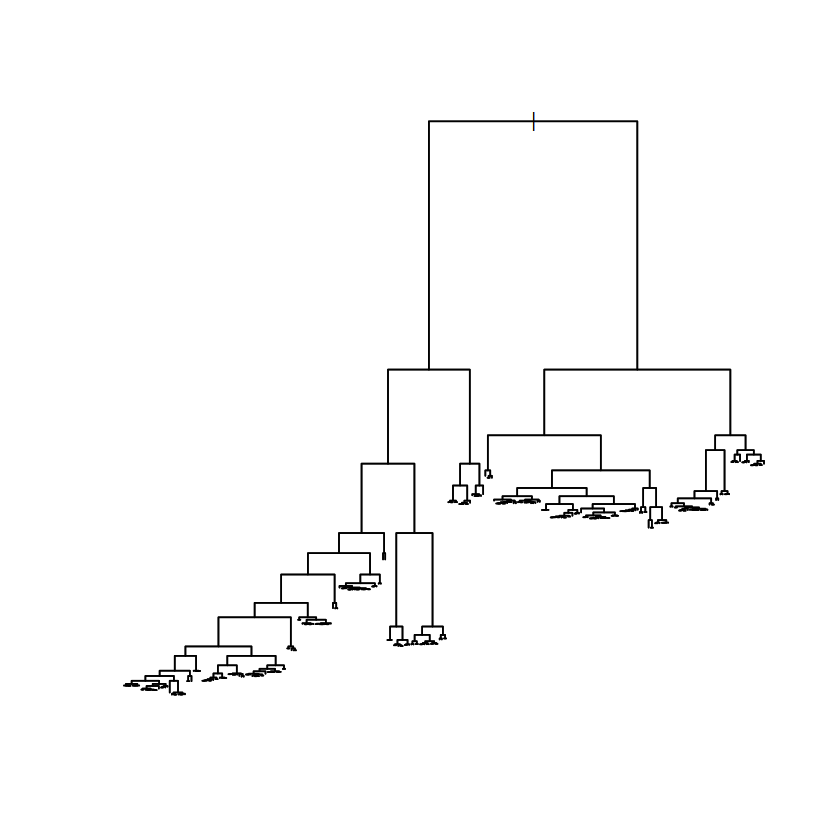

In [22]:
#starting with maximally complex tree(interpolating)
full_tree = tree(LC50 ~ ., data = train, mincut=1, mindev = 0, minsize = 2)
plot(full_tree)

Find sequence of pruned trees unsing cv.tree, with 5 folds

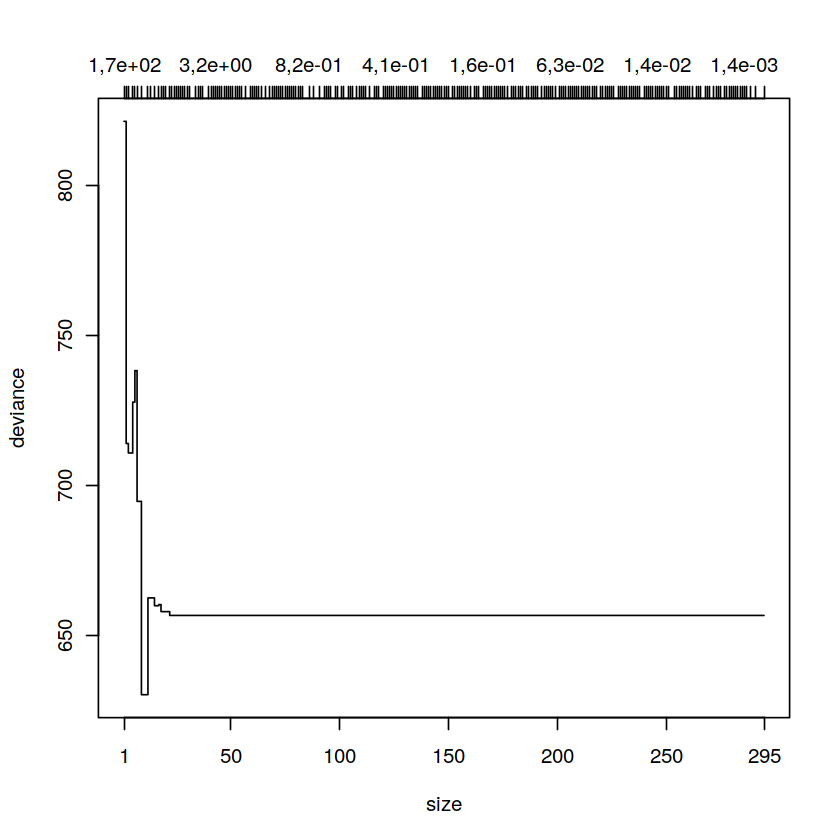

In [23]:
cv = cv.tree(full_tree, K = 5)
plot(cv)

Best tree:

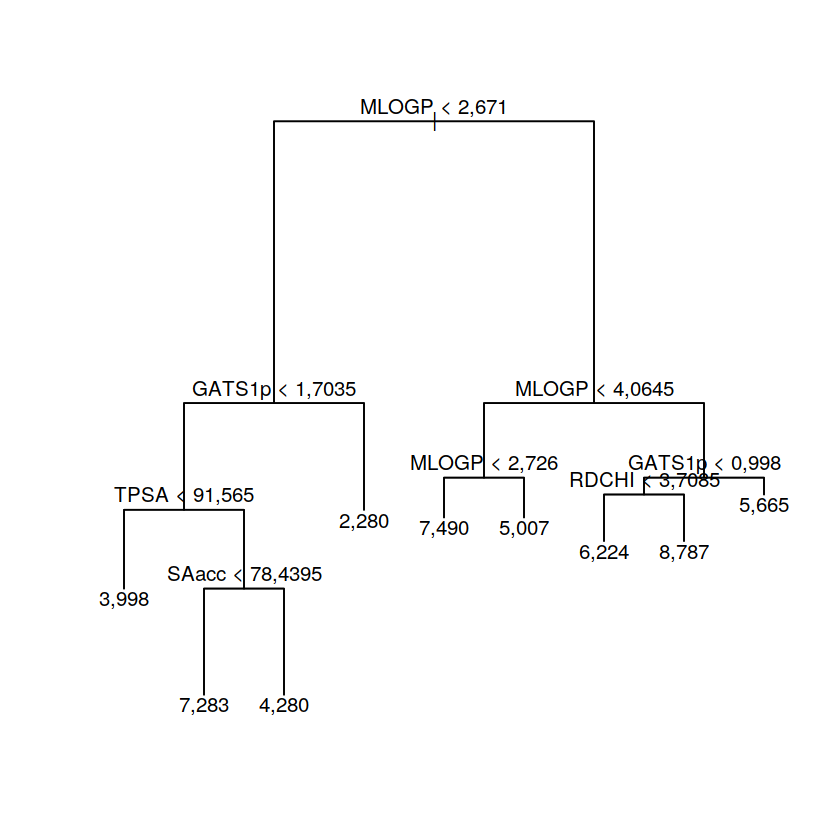

In [24]:
min_idx = which.min(cv$dev)  #index of best model
best_size = cv$size[min_idx] #size of best model

best_tree = prune.tree(full_tree, best = best_size) #make best model
plot(best_tree)
text(best_tree)

In [25]:
y_predicted_train = predict(best_tree, newdata = train)
mse_train = mean((y_predicted_train - train$LC50)^2)

y_predicted_test = predict(best_tree, newdata = test)
mse_test = mean((y_predicted_test - test$LC50)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

[1] "MSE train: 2,35148990703574"
[1] "MSE test: 2,76393281776119"


## Comparing all models

The best model turned out to be forward selection/backward elimination with AIC criterion, with train and test MSE of $1.32$ and $1.52$, respectivly. It managed to include 6 of the 8 features, excluding H050 and C040, which from earlier was the least significant.

Ridge with was not better, with train and test MSE of $1,31$ and $1,56$. In theory, Ridge is good at dealing with 
very correlated features. From subselection, we hypothesised that the features was not particularly correlated, so this may explained why little was gained from including Ridge.

GAM with smoothing splined tended to overfit, as the train and test MSE was $0.93$ and $1,82$. This was partially removed by reducing the number of knots for each spline, but still proved a worse model.

Regression tree performed the worst, with train and test MSE $2.35$ and $2.76$. The model seems to be very seed-dependent. Tree models are particularly noise models, and the bad performance is likely due to little available data. 

# Problem 2

In [26]:
data(PimaIndiansDiabetes)
summary(PimaIndiansDiabetes)

    pregnant         glucose         pressure         triceps     
 Min.   : 0,000   Min.   :  0,0   Min.   :  0,00   Min.   : 0,00  
 1st Qu.: 1,000   1st Qu.: 99,0   1st Qu.: 62,00   1st Qu.: 0,00  
 Median : 3,000   Median :117,0   Median : 72,00   Median :23,00  
 Mean   : 3,845   Mean   :120,9   Mean   : 69,11   Mean   :20,54  
 3rd Qu.: 6,000   3rd Qu.:140,2   3rd Qu.: 80,00   3rd Qu.:32,00  
 Max.   :17,000   Max.   :199,0   Max.   :122,00   Max.   :99,00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0,0   Min.   : 0,00   Min.   :0,0780   Min.   :21,00   neg:500  
 1st Qu.:  0,0   1st Qu.:27,30   1st Qu.:0,2437   1st Qu.:24,00   pos:268  
 Median : 30,5   Median :32,00   Median :0,3725   Median :29,00            
 Mean   : 79,8   Mean   :31,99   Mean   :0,4719   Mean   :33,24            
 3rd Qu.:127,2   3rd Qu.:36,60   3rd Qu.:0,6262   3rd Qu.:41,00            
 Max.   :846,0   Max.   :67,10   Max.   :2,4200   Max.   :81,00            

In [27]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)
x = PimaIndiansDiabetes[,-9]
y = PimaIndiansDiabetes[,9]

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

x_train = x[train_idx,]
x_test = x[-train_idx,]

y_train = y[train_idx]
y_test = y[-train_idx]

### KNN with CV

In [28]:
#10 fold cv
k_max = 50
k_values = seq(1, k_max)
class_rate_10fold = rep(0, k_max)
class_rate_loo = rep(0, k_max)
class_rate_test = rep(0, k_max)


for (k in 1:k_max)
{
    folds_10 = cut(seq(1,nrow(x_train)),breaks=10,labels=FALSE)
    for(i in 1:10)
    {
        val_idx = which(folds_10==i,arr.ind=TRUE)
        x_val_cv = x_train[val_idx, ]
        y_val_cv = y_train[val_idx]
        
        x_train_cv = x_train[-val_idx, ]
        y_train_cv = y_train[-val_idx]
        
        y_pred = knn(x_train_cv, x_val_cv, y_train_cv, k = k)
        
        class_rate_10fold[k] = class_rate_10fold[k] + mean(y_pred == y_val_cv)
    }
    class_rate_10fold[k] = class_rate_10fold[k]/10
    
    
    folds_loo = cut(seq(1,nrow(x_train)),breaks=train_size,labels=FALSE)
    for(i in 1:train_size)
    {
        val_idx = which(folds_loo==i,arr.ind=TRUE)
        x_val_cv = x_train[val_idx, ]
        y_val_cv = y_train[val_idx]
        
        x_train_cv = x_train[-val_idx, ]
        y_train_cv = y_train[-val_idx]
        
        y_pred = knn(x_train_cv, x_val_cv, y_train_cv, k = k)
        
        class_rate_loo[k] = class_rate_loo[k] + mean(y_pred == y_val_cv)
    }
    class_rate_loo[k] = class_rate_loo[k]/train_size
    
    
    y_pred = knn(x_train, x_test, y_train, k = k)
    class_rate_test[k] = mean(y_pred == y_test)
}


[1] "Best k 10fold: 37"
[1] "Best k LOO: 15"
[1] "Best k Test: 11"
[1] "Classification rate for k chosen by LOOCV: 0,772727272727273"


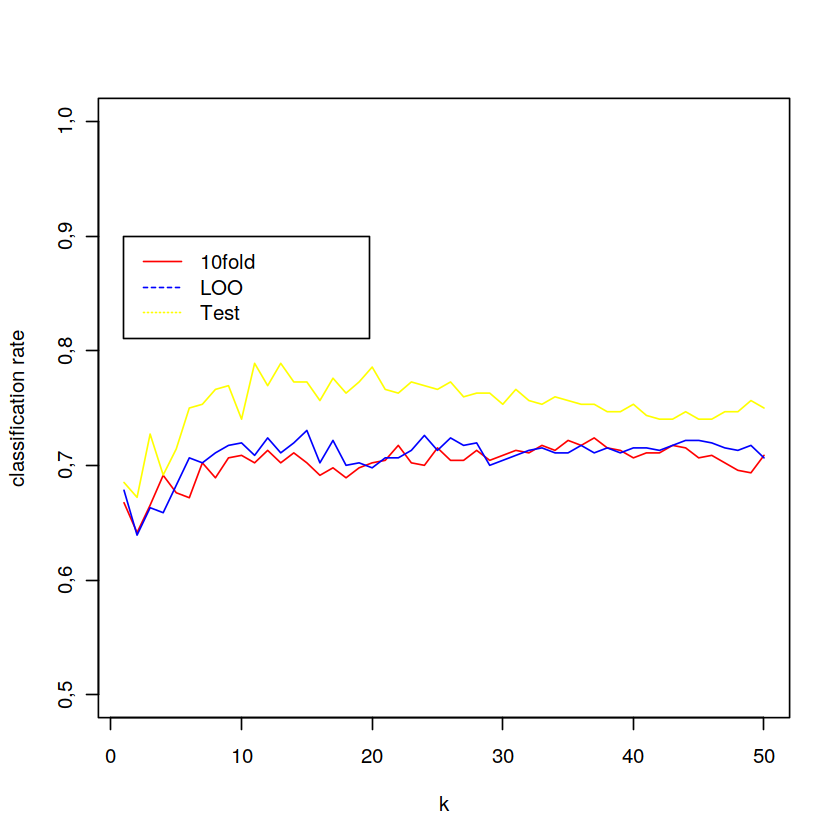

In [29]:
plot(k_values, class_rate_10fold, type="l", col="red", xlab = "k", ylab = "classification rate", ylim=c(0.5,1))
lines(k_values, class_rate_loo, col="blue")
lines(k_values, class_rate_test, col="yellow")
legend(1, 0.9, legend=c("10fold", "LOO", "Test"), col=c("red", "blue", "yellow"), lty=1:3)

print(paste0("Best k 10fold: ",which.max(class_rate_10fold)))
print(paste0("Best k LOO: ",   which.max(class_rate_loo)))
print(paste0("Best k Test: ",  which.max(class_rate_test)))
print(paste0("Classification rate for k chosen by LOOCV: ",  class_rate_test[14]))

From the above plot and printed values, 10-fold, LOOCV and test data estimated the best k to be 37, 15 and 11, repectibly. It's to expect that LOOCV suggest a more complex model than 10-fold, as it is more susceptible to variance and overfitting since basically all the data are fitted for each run. However, the independent test set suggested an even more complex model. This could be the result of having few samples and many features, and might be just a fluke.

Best k chosen by LOOCV yielded a classification rate of 0.77 on test data.

### GAM

In [30]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes[train_idx,]
test = PimaIndiansDiabetes[-train_idx,]

In [31]:
fit = gam(diabetes ~ 
          s(pregnant) + 
          s(glucose) + 
          s(pressure) +
          s(triceps) + 
          s(insulin) +
          s(mass) +
          s(pedigree) +
          s(age),
          family = binomial("logit"),
          data=train)

In [32]:
y_pred_test = round(1/(1 + exp(-predict.gam(fit, newdata=test)))) #invert link function to calculate prediction
y_true_test = as.numeric(test$diabetes) - 1

print(mean(y_true_test == y_pred_test))

[1] 0,7597403


The gam model obtained classification rate of $0.76$ on test data, slightly worse than KNN. This is likely due to overfitting, since the GAM is a very complex model.

## Classification tree

In [33]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes[train_idx,]
test = PimaIndiansDiabetes[-train_idx,]

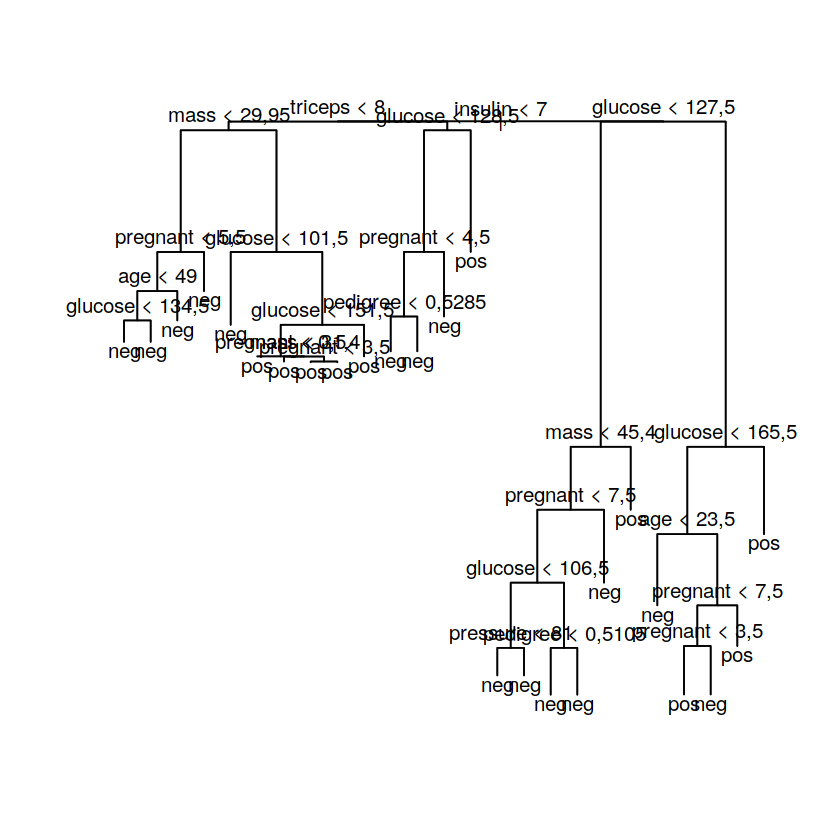

In [34]:
clas_tree = tree(diabetes ~ ., split = "gini", data = train, mincut = 5, minsize = 30, mindev = 0.01)
plot(clas_tree)
text(clas_tree)

In [35]:
y_pred_train = round(predict(clas_tree, newdata = train)[,2])
y_true_train = as.numeric(train$diabetes)-1
clas_rate_train = mean(y_pred_train == y_true_train)

y_pred_test = round(predict(clas_tree, newdata = test)[,2])
y_true_test = as.numeric(test$diabetes)-1
clas_rate_test = mean(y_pred_test == y_true_test)

print(paste0("Classification rate train: ", clas_rate_train))
print(paste0("Classification rate test: ", clas_rate_test))

[1] "Classification rate train: 0,771739130434783"
[1] "Classification rate test: 0,743506493506494"


0.74 classification rate on test data, so not better than knn and GAM

## Bagging

In [36]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes[train_idx,]
test = PimaIndiansDiabetes[-train_idx,]
y_true_test = as.numeric(test$diabetes)-1

We perform bagging by creating classification trees on different boot strap samples. Each tree is fittet with parameters as the previous classification tree

In [37]:
B = 100
y_pred_test = matrix(, nrow = nrow(test), ncol = B)
for (i in 1:B)
{
    n = nrow(train)
    idx = sample(seq_len(n), size = n, replace = TRUE)
    train_boot = train[idx,]
    
    fit = tree(diabetes ~ ., split = "gini", data = train_boot, mincut = 5, minsize = 30, mindev = 0.01)
    
    y_pred_test[,i] = predict(fit, newdata = test)[,2]
}

In [38]:
y_pred_probability = round(rowMeans(y_pred_test))
clas_rate_probability = mean(y_pred_probability == y_true_test)


y_pred_consensus = round(rowMeans(round(y_pred_test)))
clas_rate_consensus = mean(y_pred_consensus == y_true_test)

print(paste0("Classification rate probability: ", clas_rate_probability))
print(paste0("Classification rate consensus: ", clas_rate_consensus))

[1] "Classification rate probability: 0,730519480519481"
[1] "Classification rate consensus: 0,743506493506494"


In this example, probability vote and consesus vote performed almost equally good. It could be expected that probability voting performs better, since models that are very sure of their decision is weighted more, whereas votes in consensus are weighted equally, making it probable that bad models might get a large influence. Also, the ensamble was not any better than the single tree, which was not expected.

### Random Forest

In [39]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes[train_idx,]
test = PimaIndiansDiabetes[-train_idx,]

In [40]:
rf = randomForest(diabetes ~ .,data=train)

In [41]:
y_pred = predict(rf, newdata=test)
clas_rate_rf = mean(y_pred == test$diabetes)
print(paste0("Classification rate random forest: ", clas_rate_rf))

[1] "Classification rate random forest: 0,766233766233766"


At classification rate of 0.77, it is very close in preformance to KNN

### AdaBoost

In [42]:
set.seed(42)
n = nrow(PimaIndiansDiabetes)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes[train_idx,]
test = PimaIndiansDiabetes[-train_idx,]

In [43]:
fit = ada(x=train[,-9], y=train[,9], iter=20, loss="logistic")
y_pred = predict(fit, test[,-9])
clas_rate_ada = mean(y_pred == test$diabetes)
print(paste0("Classification rate adaboost: ", clas_rate_ada))

[1] "Classification rate adaboost: 0,75974025974026"


Yet again, we get a model of similar accuracy as earlier, with a classification rate of $0.76$.

Perhaps due to not careful enough tweaking, most models ended up performing similarly, obtaining an accuracy between $0.74$ and $0.77$ on test set. There is a tie between KNN, random forest and ADAboost.

# New data without missing values

In [44]:
data(PimaIndiansDiabetes2)
PimaIndiansDiabetes2 = na.omit(PimaIndiansDiabetes2)
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0,000   Min.   : 56,0   Min.   : 24,00   Min.   : 7,00  
 1st Qu.: 1,000   1st Qu.: 99,0   1st Qu.: 62,00   1st Qu.:21,00  
 Median : 2,000   Median :119,0   Median : 70,00   Median :29,00  
 Mean   : 3,301   Mean   :122,6   Mean   : 70,66   Mean   :29,15  
 3rd Qu.: 5,000   3rd Qu.:143,0   3rd Qu.: 78,00   3rd Qu.:37,00  
 Max.   :17,000   Max.   :198,0   Max.   :110,00   Max.   :63,00  
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14,00   Min.   :18,20   Min.   :0,0850   Min.   :21,00   neg:262  
 1st Qu.: 76,75   1st Qu.:28,40   1st Qu.:0,2697   1st Qu.:23,00   pos:130  
 Median :125,50   Median :33,20   Median :0,4495   Median :27,00            
 Mean   :156,06   Mean   :33,09   Mean   :0,5230   Mean   :30,86            
 3rd Qu.:190,00   3rd Qu.:37,10   3rd Qu.:0,6870   3rd Qu.:36,00            
 Max.   :846,00   Max.   :67,10   Max.   :2,4200   Max.   :81,00     

In [45]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)
x = PimaIndiansDiabetes2[,-9]
y = PimaIndiansDiabetes2[,9]

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

x_train = x[train_idx,]
x_test = x[-train_idx,]

y_train = y[train_idx]
y_test = y[-train_idx]

### KNN

In [46]:
y_pred = knn(x_train, x_test, y_train, k = 15)
class_rate_test = mean(y_pred == y_test)
print(paste0("Classification rate knn: ", class_rate_test))

[1] "Classification rate knn: 0,713375796178344"


### GAM

In [47]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes2[train_idx,]
test = PimaIndiansDiabetes2[-train_idx,]

In [48]:
fit = gam(diabetes ~ 
          s(pregnant) + 
          s(glucose) + 
          s(pressure) +
          s(triceps) + 
          s(insulin) +
          s(mass) +
          s(pedigree) +
          s(age),
          family = binomial("logit"),
          data=train)

In [49]:
y_pred_test = round(1/(1 + exp(-predict.gam(fit, newdata=test)))) #invert link function to calculate prediction
y_true_test = as.numeric(test$diabetes) - 1

clas_rate_gam = mean(y_true_test == y_pred_test)

print(paste0("Classification rate gam: ", clas_rate_gam))

[1] "Classification rate gam: 0,770700636942675"


### Classification tree

In [50]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes2[train_idx,]
test = PimaIndiansDiabetes2[-train_idx,]

In [51]:
clas_tree = tree(diabetes ~ ., split = "gini", data = train, mincut = 5, minsize = 30, mindev = 0.01)

y_pred_test = round(predict(clas_tree, newdata = test)[,2])
y_true_test = as.numeric(test$diabetes)-1
clas_rate_tree = mean(y_pred_test == y_true_test)

print(paste0("Classification rate test: ", clas_rate_tree))

[1] "Classification rate test: 0,707006369426752"


### Bagging

In [52]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes2[train_idx,]
test = PimaIndiansDiabetes2[-train_idx,]
y_true_test = as.numeric(test$diabetes)-1

In [53]:
B = 100
y_pred_test = matrix(, nrow = nrow(test), ncol = B)
for (i in 1:B)
{
    n = nrow(train)
    idx = sample(seq_len(n), size = n, replace = TRUE)
    train_boot = train[idx,]
    
    fit = tree(diabetes ~ ., split = "gini", data = train_boot, mincut = 5, minsize = 30, mindev = 0.01)
    
    y_pred_test[,i] = predict(fit, newdata = test)[,2]
}

In [54]:
y_pred_probability = round(rowMeans(y_pred_test))
clas_rate_probability = mean(y_pred_probability == y_true_test)


y_pred_consensus = round(rowMeans(round(y_pred_test)))
clas_rate_consensus = mean(y_pred_consensus == y_true_test)

print(paste0("Classification rate probability: ", clas_rate_probability))
print(paste0("Classification rate consensus: ", clas_rate_consensus))

[1] "Classification rate probability: 0,726114649681529"
[1] "Classification rate consensus: 0,732484076433121"


### Random Forest

In [55]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes2[train_idx,]
test = PimaIndiansDiabetes2[-train_idx,]

In [56]:
rf = randomForest(diabetes ~ .,data=train)
y_pred = predict(rf, newdata=test)
clas_rate_rf = mean(y_pred == test$diabetes)
print(paste0("Classification rate random forest: ", clas_rate_rf))

[1] "Classification rate random forest: 0,726114649681529"


### ADAboost

In [57]:
set.seed(42)
n = nrow(PimaIndiansDiabetes2)

train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = PimaIndiansDiabetes2[train_idx,]
test = PimaIndiansDiabetes2[-train_idx,]

In [58]:
fit = ada(x=train[,-9], y=train[,9], iter=20, loss="logistic")
y_pred = predict(fit, test[,-9])
clas_rate_ada = mean(y_pred == test$diabetes)
print(paste0("Classification rate adaboost: ", clas_rate_ada))

[1] "Classification rate adaboost: 0,745222929936306"


### Comment on dataset without missing values

Contrary to intuition, almost all methods performed worse using the data with missing values removed. A possible explaination is that there is some systematic in the way the missing values occur. For example, it could be that testing on people with diabetes more often resulted in missing values, for whatever reason. In the original data set, this would appear at zeros for various features, hinting that the patient has diabetes.

### Final comment

Due to several busy weeks and a particularly long mandatory problem set (implementing this many different methods in R was a bit dauting!), this work turned very rough. I had not time to implement neural networks, and some of the results are a bit sketchy, though I tried to make a good discussion as far as I was able. 